In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import plotly.express as px
import plotly.graph_objects as go

## Load  / Prep Data

In [4]:
treedf = pd.read_csv('./Final_app_work/categorized_data.csv')
treedf.head().T

,0,1,2,3,4
Unnamed: 0,1,2,4,5,7
site,AK,AK,AK,AK,AK
tree,1A,1A,1A,1A,1A
plot,1,1,1,1,1
species,P glauca,P glauca,P glauca,P glauca,P glauca
Date,2019-01-01,2019-02-01,2019-05-01,2019-06-01,2018-07-01
longitude,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571
latitude,68.018576,68.018576,68.018576,68.018576,68.018576
da,1,1,1,1,1
mo,1,2,5,6,7


In [5]:
treedf['radius_change_micrometers'] = 10000 * treedf['change_stem_radius']

In [6]:
print(treedf.columns)

Index(['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_air_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_rank', 'solar_cat',
       'soil_moist_cat', 'growth_category', 'radius_change_micrometers'],
      dtype='object')


In [7]:
# Selecting non-categorical, non-engineered, non-target features for the analysis 
X = treedf[["average_stem_radius", "average_basal_area", 'freeze_flag',\
           "average_air_temperature", "average_air_pressure", "average_humidity", "avg_solar_irradiance", \
           "avg_soil_water_content"]].dropna()

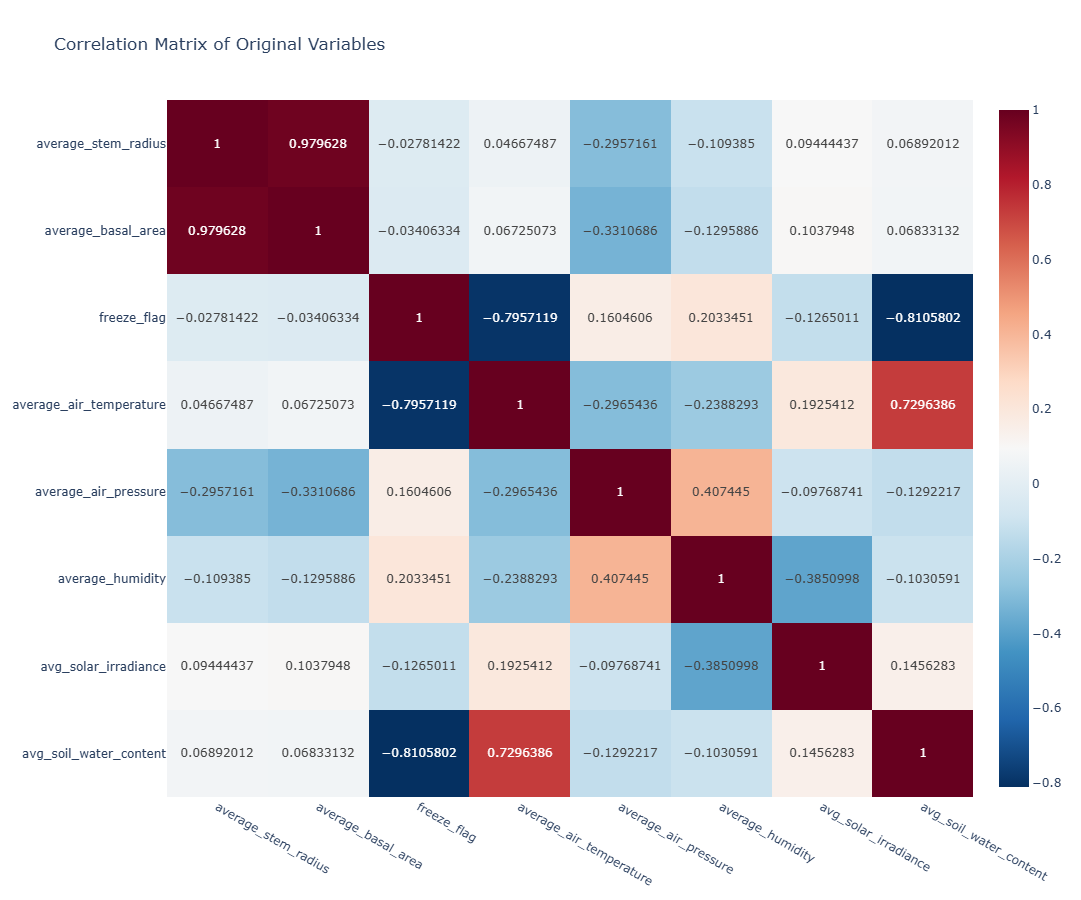

In [8]:
corr_X = X.corr()

fig_corr_X = px.imshow(
    corr_X,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Matrix of Original Variables"
)
fig_corr_X.update_layout(
    width=900,
    height=900,
)
fig_corr_X.show()

(0.0, 300.0)

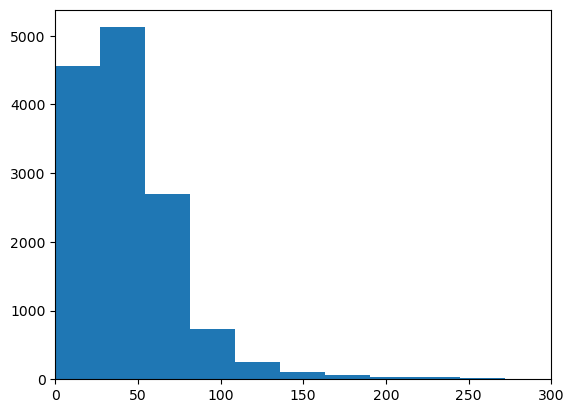

In [9]:
plt.hist(treedf['radius_change_micrometers'], bins=20)
plt.xlim(0,300)

## Creating Model

In [10]:
pca_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA())
])

pca_pipe.fit(X)

,steps,"[('scaler', ...), ('pca', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'


In [11]:
pca_model = pca_pipe.named_steps["pca"]
explained_var = pca_model.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)
n_components = len(explained_var)

ev_df = pd.DataFrame({
    "PC": np.arange(1, n_components + 1),
    "ExplainedVariance": explained_var,
    "CumulativeVariance": cum_explained_var
})


fig_scree = px.line(
    ev_df, x="PC", y="ExplainedVariance",
    markers=True,
    title="Scree Plot: Proportion of Variance Explained"
)

print('Explained variation per component:', explained_var)
print("Cumulative variation across components:", cum_explained_var)

Explained variation per component: [0.36306051 0.25829266 0.15812544 0.10825232 0.05930639 0.03045831
 0.02007739 0.00242698]
Cumulative variation across components: [0.36306051 0.62135317 0.77947861 0.88773093 0.94703732 0.97749563
 0.99757302 1.        ]


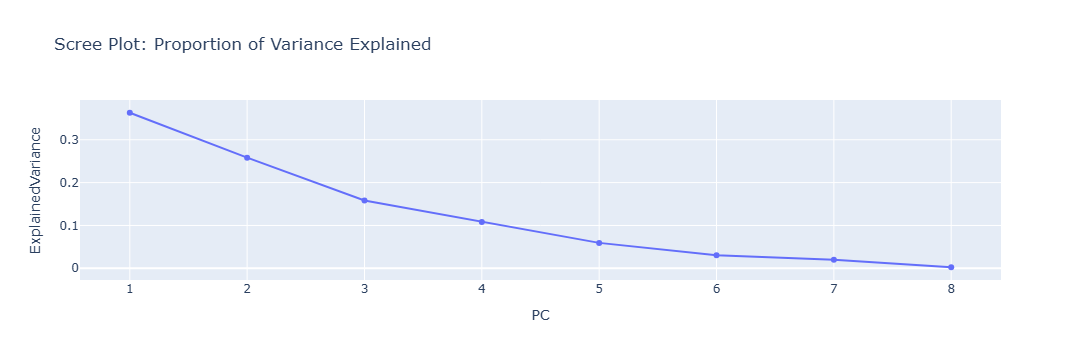

In [12]:
fig_scree.show()

In [13]:
X_pca_scores = pca_pipe.transform(X)
#pc_cols = [f"PC{i}" for i in range(1, n_components + 1)]

# Get indices of components > 0.09
important_indices = [i for i, var in enumerate(explained_var) if var > 0.09]
# Keep only PCs where explained variance > 0.09
pc_cols = [f"PC{i+1}" for i in important_indices]

#y = treedf['radius_change_micrometers']
#y = treedf['change_stem_radius']
y = treedf['change_basal_area']

scores_df = pd.DataFrame(X_pca_scores[:, important_indices], columns=pc_cols)
scores_df['Change in Stem Radius'] = y
scores_df

print(len(scores_df))
print(len(scores_df.dropna()))

13637
13637


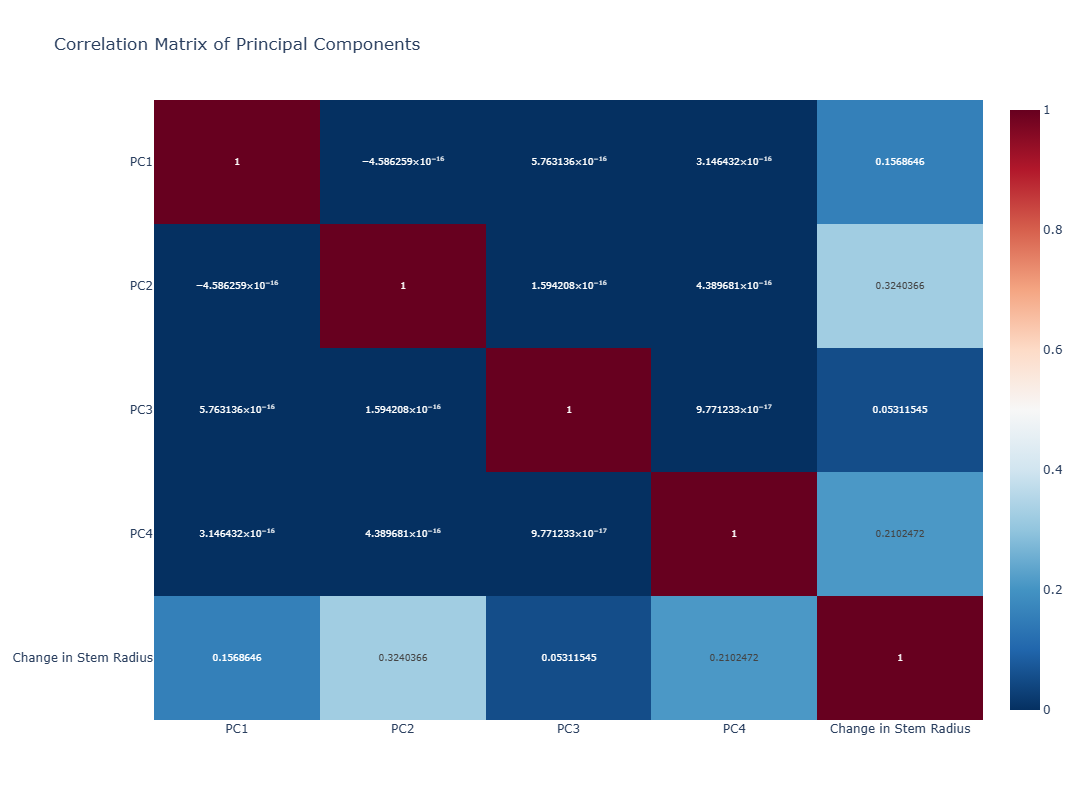

In [14]:
corr_PC = scores_df.corr()

fig_corr_PC = px.imshow(
    corr_PC,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Matrix of Principal Components"
)
fig_corr_PC.update_layout(
    width=800,
    height=800,
)
fig_corr_PC.show()

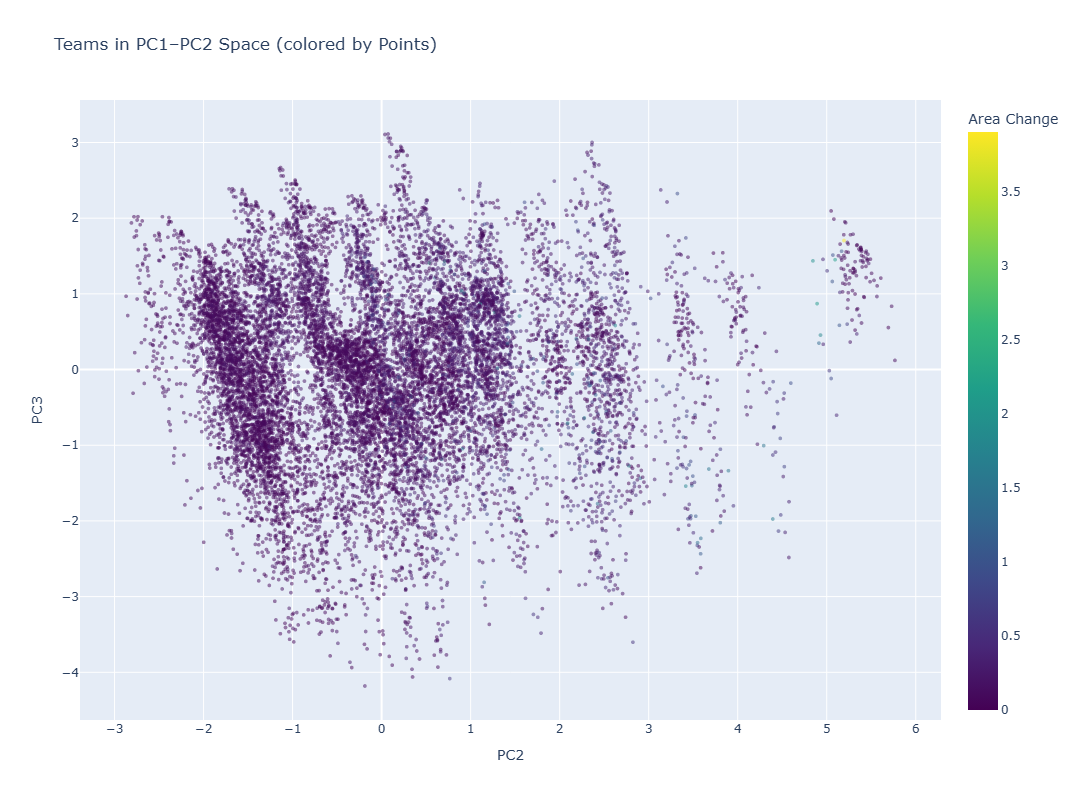

In [15]:
X_pca_scores = pca_pipe.transform(X)

# Get indices of components > 0.09
important_indices = [i for i, var in enumerate(explained_var) if var > 0.09]
# Keep only PCs where explained variance > 0.09
pc_cols = [f"PC{i+1}" for i in important_indices]

X_pca_scores = X_pca_scores[:, important_indices]

scores_df = pd.DataFrame(X_pca_scores, columns=pc_cols)
scores_df["Area Change"] = treedf['change_basal_area']
scores_df["Stem Radius Change (micrometers)"] = treedf['radius_change_micrometers']
scores_df["Stem Radius Change (centimeters)"] = treedf['change_stem_radius']
scores_df['species'] = treedf['species']
scores_df['plot'] = treedf['plot']
scores_df['Date'] = treedf['Date']


fig_scatter = px.scatter(
    scores_df,
    x="PC2", y="PC3",
    color="Area Change",
    hover_name="species",
    hover_data="Date",
    title="Teams in PC1–PC2 Space (colored by Points)",
    color_continuous_scale="Viridis",
    width=800,
    height=800,
    opacity=0.5
)

fig_scatter.update_traces(marker=dict(size=4)) 

fig_scatter.show()

## Investigating the Principal Components

In [16]:
# treedf columns
'''
['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_soil_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_cat', 'soil_moist_cat']
'''

"\n['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',\n       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',\n       'change_stem_radius', 'average_basal_area', 'change_basal_area',\n       'average_soil_temperature', 'average_air_pressure', 'average_humidity',\n       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',\n       'air_pressure_cat', 'humidity_cat', 'solar_cat', 'soil_moist_cat']\n"

In [17]:
print(scores_df.shape)
scores_df.columns

(13637, 10)


Index(['PC1', 'PC2', 'PC3', 'PC4', 'Area Change',
       'Stem Radius Change (micrometers)', 'Stem Radius Change (centimeters)',
       'species', 'plot', 'Date'],
      dtype='object')

In [18]:
print(treedf.shape)
treedf.columns

(13637, 29)


Index(['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_air_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_rank', 'solar_cat',
       'soil_moist_cat', 'growth_category', 'radius_change_micrometers'],
      dtype='object')

In [19]:
result = pd.concat([treedf, scores_df],axis=1)
result.sort_values('radius_change_micrometers', ascending=False).tail(20).T

,1950,1893,9673,9676,9677,900,9680,12324,12343,12354,1939,9604,9607,988,935,945,12196,12197,1829,9678
Unnamed: 0,3369,3287,15839,15844,15845,1639,15851,23311,23397,23443,3354,15711,15717,1803,1703,1723,22689,22690,3189,15847
site,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK
tree,1F,1F,3A,3A,3A,1C,3A,5E,5E,5E,1F,3A,3A,1D,1C,1C,5C,5C,1F,3A
plot,1,1,3,3,3,1,3,5,5,5,1,3,3,1,1,1,5,5,1,3
species,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca
Date,2019-05-26,2019-05-20,2018-06-24,2017-08-24,2017-09-24,2019-02-25,2018-02-25,2019-02-08,2019-01-12,2019-02-14,2019-02-25,2017-12-18,2018-03-19,2018-12-01,2019-01-28,2018-12-28,2019-01-19,2019-02-19,2018-07-13,2017-12-24
longitude,-149.71558,-149.71558,-149.75301,-149.75301,-149.75301,-149.71584,-149.75301,-149.76123,-149.76123,-149.76123,-149.71558,-149.75301,-149.75301,-149.71586,-149.71584,-149.71584,-149.76131,-149.76131,-149.71558,-149.75301
latitude,68.018659,68.018659,67.995233,67.995233,67.995233,68.018696,67.995233,67.984808,67.984808,67.984808,68.018659,67.995233,67.995233,68.018735,68.018696,68.018696,67.984964,67.984964,68.018659,67.995233
da,26,20,24,24,24,25,25,8,12,14,25,18,19,1,28,28,19,19,13,24
mo,5,5,6,8,9,2,2,2,1,2,2,12,3,12,1,12,1,2,7,12


In [22]:
# Calculate correlation with y
n_actual_components = X_pca_scores.shape[1]

pc_y_correlations = []
for i in range(n_actual_components):
    corr = np.corrcoef(X_pca_scores[:, i], y)[0, 1]
    pc_y_correlations.append(abs(corr))

# Select PCs with strong correlation to y (not just high variance in X)
correlation_threshold = 0.2  # Adjust this
important_indices = [i for i, corr in enumerate(pc_y_correlations) if corr > correlation_threshold]
pc_cols = [f"PC{i+1}" for i in important_indices]

## Loadings

In [23]:
loadings = pca_model.components_.T[:, :2]
loading_df = pd.DataFrame(
    loadings,
    index=X.columns,
    columns=["PC1_loading", "PC2_loading"]
)

In [24]:
loading_df.head(10).T

,average_stem_radius,average_basal_area,freeze_flag,average_air_temperature,average_air_pressure,average_humidity,avg_solar_irradiance,avg_soil_water_content
PC1_loading,0.233144,0.243813,-0.476574,0.491108,-0.295712,-0.273378,0.211717,0.459221
PC2_loading,0.589742,0.591855,0.300212,-0.250079,-0.243408,-0.103868,0.051085,-0.276767


In [25]:
print(result['growth_category'].unique())

['A Lot of Growth' 'A Little Growth' 'No Growth']


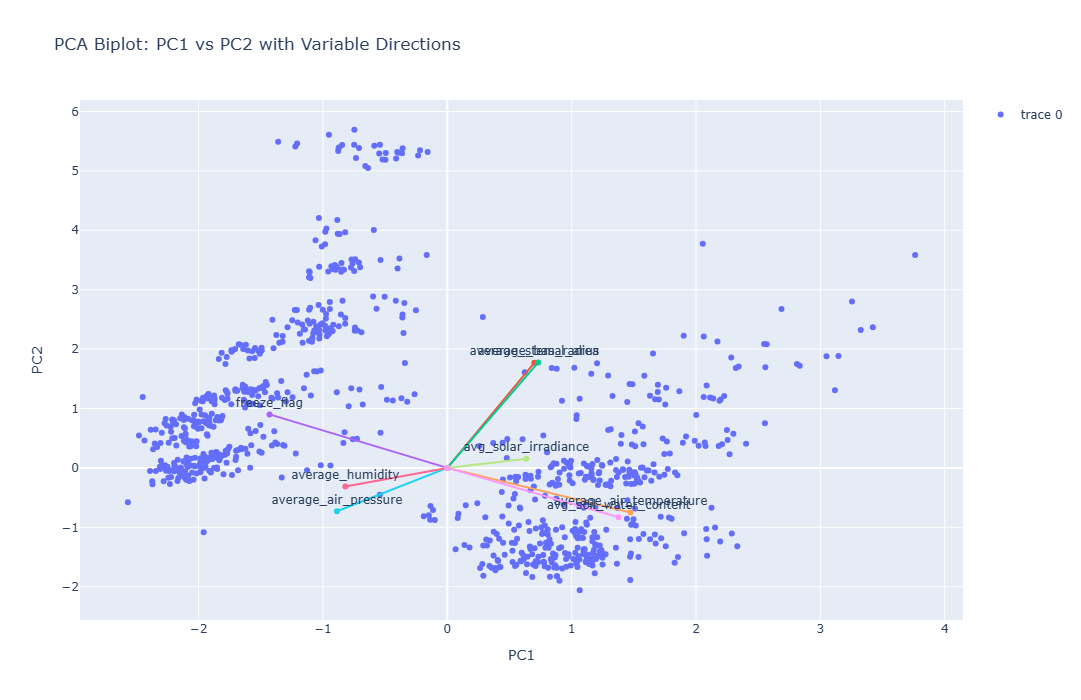

In [26]:
# Still two 'species' cols for some reason
result = result.loc[:, ~result.columns.duplicated()]
# Filter based on growth category
growth_cat = 'No Growth'
#growth_cat = 'A Little Growth'
#growth_cat = 'A Lot of Growth'
result_no_growth = result[result["growth_category"] == "No Growth"]

arrow_scale = 3

fig = go.Figure()


fig.add_trace(go.Scatter(
    x=result_no_growth["PC1"],
    y=result_no_growth["PC2"],
    mode="markers+text",
    #text=result_no_growth["species"],
    textposition="top center",
    #name="species",
    hovertext=[f"{t}, Change in Radius={p}" for t, p in zip(result["species"], result["radius_change_micrometers"])],
    #hoverinfo="text"
))


for var_name, row in loading_df.iterrows():
    x_arrow = row["PC1_loading"] * arrow_scale
    y_arrow = row["PC2_loading"] * arrow_scale


    fig.add_trace(go.Scatter(
        x=[0, x_arrow],
        y=[0, y_arrow],
        mode="lines+markers+text",
        text=[None, var_name],
        textposition="top center",
        showlegend=False
    ))

fig.update_layout(
    title="PCA Biplot: PC1 vs PC2 with Variable Directions",
    xaxis_title="PC1",
    yaxis_title="PC2",
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True),
    width=800,
    height=700
)

fig.show()


## Principal Component REGRESSION

In [ ]:
# NEED TO FIND CORRELATION BETWEEN COMPONENT AND Y

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Pipe with various numbers of principal components
n_pcs = 4
pcr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_pcs)),
    ("linreg", LinearRegression())
])

pcr_pipe.fit(X_train, y_train)


,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,4
,copy,True
,whiten,False
,svd_solver,'auto'


In [29]:
train_r2 = pcr_pipe.score(X_train, y_train)
test_r2  = pcr_pipe.score(X_test, y_test)


y_train_pred = pcr_pipe.predict(X_train)
y_test_pred  = pcr_pipe.predict(X_test)

In [30]:
train_rmse = np.sqrt(np.mean((y_train - y_train_pred)**2))
test_rmse  = np.sqrt(np.mean((y_test - y_test_pred)**2))

print(f"Using n_components = {n_pcs}")
print(f"Train R²  : {train_r2:.4f}")
print(f"Test  R²  : {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")

Using n_components = 4
Train R²  : 0.1780
Test  R²  : 0.1734
Train RMSE: 0.1441
Test  RMSE: 0.1513


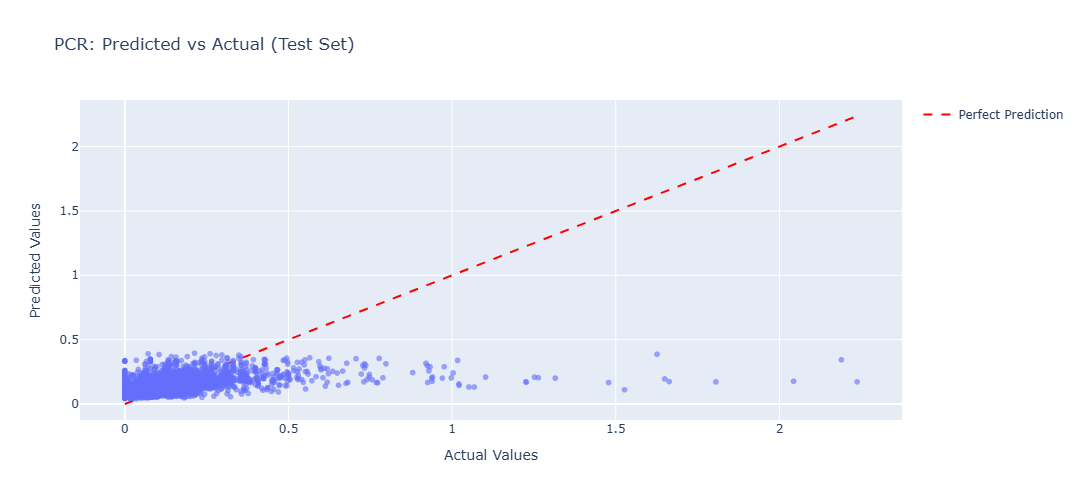

In [31]:
import plotly.express as px

# Predicted vs Actual plot for test data
fig = px.scatter(
    x=y_test, 
    y=y_test_pred,
    labels={'x': 'Actual Values', 'y': 'Predicted Values'},
    title='PCR: Predicted vs Actual (Test Set)',
    opacity=0.6,
    width=600,
    height=500
)

# Add perfect prediction line (y=x)
fig.add_scatter(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(color='red', dash='dash')
)

fig.show()

In [32]:
# Correlation with target
correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations)

average_stem_radius        0.392009
average_basal_area         0.376200
avg_solar_irradiance       0.172036
average_air_temperature    0.027062
avg_soil_water_content     0.023645
freeze_flag                0.007023
average_air_pressure      -0.031387
average_humidity          -0.064797
dtype: float64


In [33]:
treedf.value_counts('growth_category')

growth_category
A Lot of Growth    6457
A Little Growth    6323
No Growth           857
Name: count, dtype: int64